docker run -it --rm --runtime=nvidia -p 8888:8888 tensorflow/tensorflow:latest-gpu-jupyter

https://docs.arduino.cc/tutorials/nano-33-ble-sense-rev2/get-started-with-machine-learning/

https://github.com/tensorflow/tflite-micro-arduino-examples
 

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf

from hebbian_correlation_matrix import HebbianCorrelationMatrix
from spice_net_som import SpiceNetSom

In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
som_neuron_count = 30

In [4]:
df = pd.read_csv('test_data.csv')
df

init    result
0    -0.868245 -0.654525
1     0.866917  0.651528
2    -0.102037 -0.001062
3     0.602888  0.219135
4     0.838314  0.589141
...        ...       ...
2995 -0.181318 -0.005961
2996  0.314093  0.030987
2997 -0.313361 -0.030771
2998  0.144365  0.003009
2999  0.125558  0.001979

[3000 rows x 2 columns]

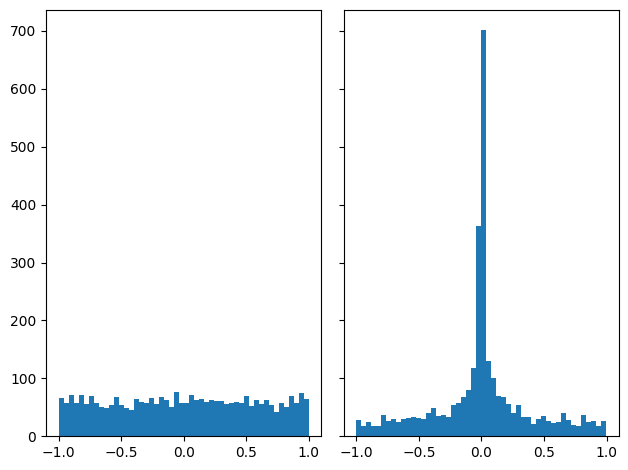

In [5]:
n_bins = 50

_, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(df['init'], bins=n_bins)
axs[1].hist(df['result'], bins=n_bins)

plt.show()

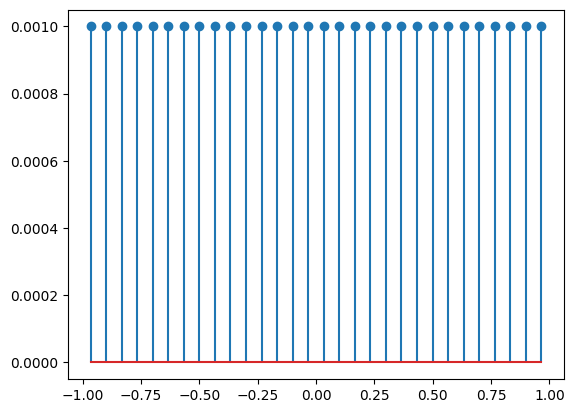

In [6]:
som = SpiceNetSom(som_neuron_count, df['init'].min(), df['init'].max())
stem_x_values = som.get_as_matrix()[:, 0]
stem_y_values = som.get_as_matrix()[:, 1]

plt.stem(stem_x_values, stem_y_values)
plt.show()

In [7]:
som.fit(df['result'], 10)
# som.print_neurons()

In [8]:
stem_x_values = som.get_as_matrix()[:, 0]
stem_y_values = som.get_as_matrix()[:, 1]

fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=True)
fig.set_size_inches(18.5, 21.0, forward=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0, 0].stem(stem_x_values, stem_y_values)

# first row of plots
xmax = axs[0, 0].viewLim.xmax
xmin = axs[0, 0].viewLim.xmin

# second row of plots
x_plt_vals = np.linspace(xmin, xmax, 500)
activation_values = som.calculate_activation_values(x_plt_vals)
num_rows, num_cols = activation_values.shape
for i in range(num_rows):
    axs[1, 0].plot(x_plt_vals, activation_values[i, 2:], linewidth=2)
axs[0, 1].hist(df['result'], bins=n_bins)
axs[1, 1].hist(df['result'], bins=n_bins)
plt.show()

In [9]:
df_som_1 = pd.DataFrame(activation_values[:, 2:].transpose(), index=x_plt_vals)
# df_som_1

In [10]:
fig = px.line(df_som_1)
fig.show(title='Activation values')

In [11]:
som_2 = SpiceNetSom(som_neuron_count, df['init'].min(), df['init'].max())
som_2.fit(df['init'], 10)
df_second_som = pd.DataFrame(som_2.calculate_activation_values(x_plt_vals)[:, 2:].transpose(), index=x_plt_vals)
fig = px.line(df_second_som)
fig.show(title='Activation values')

In [12]:
hebbian_correlation_matrix = HebbianCorrelationMatrix(som, som_2)

In [13]:
hebbian_correlation_matrix.fit(df['init'], df['result'], 1)

C:\Users\Fabian\source\repos\spicenet-embedded\code\embedded\hebbian_correlation_matrix.py:35: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\Fabian\source\repos\spicenet-embedded\code\embedded\hebbian_correlation_matrix.py:31: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\Fabian\source\repos\spicenet-embedded\code\embedded\hebbian_correlation_matrix.py:27: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\Fabian\source\repos\spicenet-embedded\code\embedded\hebbian_correlation_matrix.py:29: RuntimeWarning:

overflow encountered in scalar multiply



In [14]:
fig = px.imshow(hebbian_correlation_matrix.get_matrix(), text_auto=True, aspect="auto")
fig.update_layout(yaxis=dict(scaleanchor='x'))
fig.show()

In [31]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

C:\Users\Fabian\source\repos\spicenet-embedded\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [33]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.27208045, -0.5393212 ,  0.37512323,  0.43569848,  0.42299905,
        -0.16296527,  0.08440638, -0.01089362,  0.08050586, -0.05162239]],
      dtype=float32)

In [34]:
tf.nn.softmax(predictions).numpy()


array([[0.11531068, 0.05122505, 0.12782638, 0.13580883, 0.13409503,
        0.07463312, 0.09557927, 0.08689114, 0.0952072 , 0.08342326]],
      dtype=float32)

In [35]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

2.5951707

In [36]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [37]:
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         patience=3)

model.fit(x_train, y_train, epochs=5, callbacks=[callback])

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8627 - loss: 0.4731
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9557 - loss: 0.1482
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9655 - loss: 0.1077
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9725 - loss: 0.0870
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9762 - loss: 0.0743


In [38]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - 1ms/step - accuracy: 0.9754 - loss: 0.0770


[0.07702196389436722, 0.9753999710083008]